In [61]:
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
import pickle
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import networkx as nx

from data_conversions import selectData, transformData
from data_conversions import floatifyData, boolifyData, quantizeData
from sampling import mkSamps, toHisto, toProbV
from sampling import createSparseBinner as createBinner
from metropolis import mutualInfo, genMetropolisSamples
from agent_based_model import createWeightedSamplesGenerator, select_subset, createWeightSer, lnLik
from agent_based_model import load_dataset
from estimate_generic_guide_func import minimizeMe, weightedSampGen
from mutator import MSTMutator

In [62]:
    subDF, acesL, boolColL, scalarColL, fixedL, passiveL, ageL = load_dataset()

    ageMin = int(min(ageL))
    ageMax = int(max(ageL))
    scalarColL.remove('AGE')
    print('scalar columns: ', scalarColL)
    print('fixed columns: ', fixedL)
    ageDFD = {}
    range_d = None
    final_acesL = None
    final_boolColL = None
    final_scalarColL = None
    for age in range(ageMin, ageMax+1):
        ageDF = subDF[subDF.AGE==age].drop(columns=['AGE', 'FIPSST'])
        ageDFD[age], final_acesL, final_boolColL, final_scalarColL, dct = quantizeData(ageDF, acesL, boolColL, scalarColL)
        if range_d is None:
            range_d = dct
        else:
            assert dct == range_d, 'Quantized ranges do not match?' 

    boolColL = final_boolColL
    acesL = final_acesL
    scalarColL = final_scalarColL
    print('final scalar columns: ', scalarColL)
            

Index(['FIPSST', 'HHID', 'FORMTYPE', 'TOTKIDS_R', 'HHLANGUAGE', 'SC_AGE_YEARS',
       'SC_SEX', 'K2Q35A_1_YEARS', 'MOMAGE', 'K6Q41R_STILL',
       ...
       'BIRTHWT', 'CBSAFP_YN', 'FWC', 'CURRINS', 'INSTYPE', 'HOUSE_GEN',
       'HHSIZE_I', 'HHSIZE_IF', 'FPL_IF', 'INSGAP'],
      dtype='object', length=422)
scalar columns:  ['BIRTHORDER', 'FPL', 'MOMAGE', 'TOTACES', 'TOTCSHCN', 'TOTKIDS']
fixed columns:  ['BIRTHWT_VL', 'PREMATURE', 'HHLANGUAGE_ENGLISH', 'SC_FEMALE', 'SC_RACE_NATIVE', 'SC_RACE_ASIAN', 'SC_RACE_ISLANDS', 'SC_RACE_OTHER', 'SC_RACE_MIXED', 'SC_RACE_HISPANIC', 'MOMAGE_LT_20', 'MOMAGE_GT_39']
final scalar columns:  ['BIRTHORDER', 'FPL', 'MOMAGE', 'TOTACES', 'TOTCSHCN', 'TOTKIDS']


In [63]:
print(subDF['TOTACES'].count())

3388


In [64]:
print(subDF[subDF.TOTACES >= 5]['TOTACES'].count())
print(70./3388.)

70
0.02066115702479339


In [91]:
rslt_dct = {}
wt_dir = 'deep_poor_black_male_generic_guides'
for age in range(ageMin, ageMax):
    fname = os.path.join(wt_dir, '%d-%d_generic.pkl' % (age, age+1))
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            stuff = pickle.load(f)
            print('%d: %d' % (age, len(stuff)))
            rslt_dct[age] = stuff[0]
    else:
        print('no path <%s>' % fname)

6: 2
7: 2
8: 2
9: 2
10: 2
11: 2
12: 2
13: 2
14: 2
15: 2
16: 2


In [92]:
age_l = [k for k in rslt_dct]
age_l.sort()


In [93]:
prototype = pd.read_pickle('poor_black_male.pkl')
prototype = weightedSampGen(prototype, 1)
print(len(prototype.columns))
prototype

36


,RECIDX,DRUGSALCOHOL,MENTALILL,PARENTDIED,PARENTDIVORCED,PARENTJAIL,RACISM,SEEPUNCH,VIOLENCE,BIRTHWT_L,...,SC_RACE_WHITE,SPORTSTEAMS,VISIONCARE,BIRTHORDER_minusone,FPL,MOMAGE_LT_20,MOMAGE_GT_39,TOTACES,TOTCSHCN,TOTKIDS_minusone
0,-1,0,0,0,0,0,0,0,0,0,...,0,1,0,2,0,0,0,0,1,2


In [94]:
fixed_l = fixedL
print('fixed_l: ', fixed_l)
fixed_d = {elt: prototype.iloc[0][elt] for elt in fixed_l}
passive_l = passiveL
print('passive_l: ', passive_l)
aces_l = acesL
print('aces_l: ',aces_l)
advancing_l = [elt for elt in aces_l
                if elt not in fixed_l + passive_l]
print('advancing_l: ', advancing_l)
open_l = [k for k in prototype.columns]
for elt in list(fixed_d) + advancing_l + passive_l:
    open_l.remove(elt)
print('open_l: ', open_l)
col_l = open_l + advancing_l
print('col_l: ',col_l)
print(len(col_l))

fixed_l:  ['BIRTHWT_VL', 'PREMATURE', 'HHLANGUAGE_ENGLISH', 'SC_FEMALE', 'SC_RACE_NATIVE', 'SC_RACE_ASIAN', 'SC_RACE_ISLANDS', 'SC_RACE_OTHER', 'SC_RACE_MIXED', 'SC_RACE_HISPANIC', 'MOMAGE_LT_20', 'MOMAGE_GT_39']
passive_l:  ['RECIDX', 'DRUGSALCOHOL', 'MENTALILL', 'PARENTDIED', 'PARENTDIVORCED', 'PARENTJAIL', 'RACISM', 'SEEPUNCH', 'VIOLENCE', 'SC_RACE_WHITE', 'TOTCSHCN', 'TOTACES']
aces_l:  ['DRUGSALCOHOL', 'MENTALILL', 'PARENTDIED', 'PARENTDIVORCED', 'PARENTJAIL', 'RACISM', 'SEEPUNCH', 'VIOLENCE']
advancing_l:  []
open_l:  ['BIRTHWT_L', 'CLUBS', 'DENTALCARE', 'DOCTORVISIT', 'HHLANGUAGE_SPANISH', 'SC_CSHCN', 'SC_RACE_BLACK', 'SPORTSTEAMS', 'VISIONCARE', 'BIRTHORDER_minusone', 'FPL', 'TOTKIDS_minusone']
col_l:  ['BIRTHWT_L', 'CLUBS', 'DENTALCARE', 'DOCTORVISIT', 'HHLANGUAGE_SPANISH', 'SC_CSHCN', 'SC_RACE_BLACK', 'SPORTSTEAMS', 'VISIONCARE', 'BIRTHORDER_minusone', 'FPL', 'TOTKIDS_minusone']
12


In [95]:
for age in age_l:
    print(age, len(rslt_dct[age].x))

6 12
7 12
8 12
9 12
10 12
11 12
12 12
13 12
14 12
15 12
16 12


In [96]:
createWeightSer(col_l, range_d)

BIRTHWT_L              0.250000
CLUBS                  0.250000
DENTALCARE             0.250000
DOCTORVISIT            0.250000
HHLANGUAGE_SPANISH     0.250000
SC_CSHCN               0.250000
SC_RACE_BLACK          0.250000
SPORTSTEAMS            0.250000
VISIONCARE             0.250000
BIRTHORDER_minusone    0.040000
FPL                    0.015625
TOTKIDS_minusone       0.040000
dtype: float64

In [97]:
d_l = []
for age in age_l:
    d = {col:(rslt_dct[age].x[idx] if idx < len(rslt_dct[age].x) else -1.0)
                for idx, col in enumerate(col_l) }
    d['age'] = age
    d_l.append(d)
wt_df = pd.DataFrame(d_l, columns=(['age']+col_l))
wt_df

,age,BIRTHWT_L,CLUBS,DENTALCARE,DOCTORVISIT,HHLANGUAGE_SPANISH,SC_CSHCN,SC_RACE_BLACK,SPORTSTEAMS,VISIONCARE,BIRTHORDER_minusone,FPL,TOTKIDS_minusone
0,6,0.294554,0.953662,0.611930,0.230587,0.296556,0.348353,0.470207,0.978286,0.926459,0.074222,0.025305,0.158715
1,7,0.311923,0.946150,0.217410,0.170889,0.735732,0.185165,0.284780,0.157058,0.921360,0.095014,0.024898,0.090054
2,8,0.625944,0.747102,0.866755,0.529604,0.610193,0.475041,0.326721,0.395382,0.914968,0.110604,0.052831,0.119456
3,9,0.404818,0.387965,0.829552,0.499166,0.172077,0.231449,0.971047,0.238867,0.865321,0.130921,0.058507,0.135104
4,10,0.545729,0.200097,0.427458,0.270392,0.514953,0.249530,0.715270,0.562453,0.910790,0.112340,0.038522,0.152655
5,11,0.818703,0.899090,0.885880,0.275905,0.939594,0.900678,0.576316,0.306944,0.566494,0.109810,0.058817,0.116242
6,12,0.529744,0.129584,0.578909,0.333955,0.332912,0.872031,0.779522,0.776665,0.378248,0.088263,0.023302,0.087262
7,13,0.150282,0.901713,0.223648,0.609997,0.431520,0.472465,0.794731,0.133312,0.887544,0.089158,0.017427,0.054784
8,14,0.352490,0.388166,0.433501,0.355756,0.668633,0.937593,0.854248,0.411310,0.791171,0.078481,0.057182,0.070505
9,15,0.519808,0.572957,0.237170,0.534609,0.861843,0.669726,0.941947,0.966952,0.647176,0.073202,0.022712,0.043181


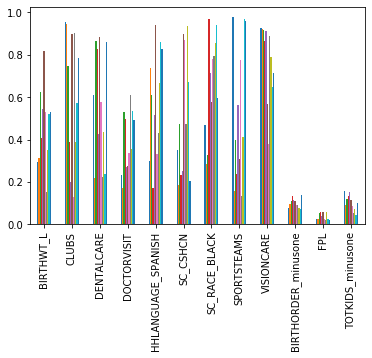

In [98]:
ax = wt_df.drop(columns='age').transpose().plot.bar(legend=False)

In [34]:
age = 11
src = 'deep_poor_black_male_generic_guides/%d-%d_generic.pkl' % (age, age+1)
seed_file = 'poor_black_male.pkl'
N_SAMP = 100
N_ITER = 1000


In [35]:
with open(src, 'rb') as f:
    rslt, pair_l = pickle.load(f)
print(pair_l)

[[array([0.78222336, 0.26153722, 0.50339275, 0.34279815, 0.35534874,
       0.76643538, 0.53954905, 0.99049857, 0.71155577, 0.02573254,
       0.0281113 , 0.14939595]), 0.6076981563854501, 1.2640035550084199], [array([0.78222336, 0.26153722, 0.50339275, 0.34279815, 0.35534874,
       0.76643538, 0.53954905, 0.99049857, 0.71155577, 0.02573254,
       0.0281113 , 0.14939595]), 0.7214858491496958, 1.2615511883603374], [array([0.22014687, 0.31063967, 0.86221564, 0.56894611, 0.49966562,
       0.85576514, 0.20952701, 0.9046686 , 0.81436715, 0.10484423,
       0.04577636, 0.10293494]), 0.7783516949111318, 1.279635343507586], [array([0.22014687, 0.31063967, 0.86221564, 0.56894611, 0.49966562,
       0.85576514, 0.20952701, 0.9046686 , 0.81436715, 0.10484423,
       0.04577636, 0.10293494]), 0.8841850686035255, 1.2729664212544936], [array([0.818703  , 0.89909004, 0.88587966, 0.27590476, 0.93959404,
       0.90067843, 0.57631568, 0.3069439 , 0.56649418, 0.10980989,
       0.05881651, 0.11624152

In [36]:
conv_l = []
xv_l = []
mi_l = []
for xv, conv, mi in pair_l:
    conv_l.append(conv)
    xv_l.append(xv)
    mi_l.append(mi)

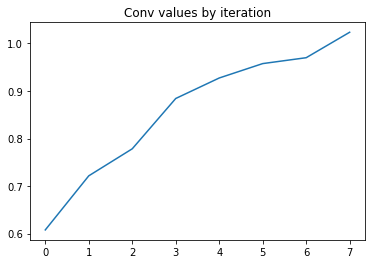

In [37]:
plt.title('Conv values by iteration')
plt.plot(*zip(*enumerate(conv_l)))
plt.show()

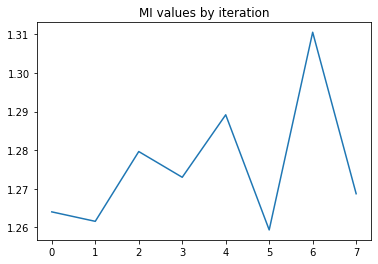

In [38]:
plt.title('MI values by iteration')
plt.plot(*zip(*enumerate(mi_l)))
plt.show()

In [13]:
prototype = weightedSampGen(pd.read_pickle(seed_file), 1)

fixed_l = fixedL
fixed_d = {elt: prototype.iloc[0][elt] for elt in fixed_l}
passive_l = passiveL
aces_l = acesL
advancing_l = [elt for elt in aces_l if elt not in list(fixed_d) + passive_l]
open_l = [k for k in prototype.columns]
for elt in list(fixed_d) + advancing_l + passive_l:
    open_l.remove(elt)
samp_gen = weightedSampGen
all_col_l = open_l + advancing_l
which_bin = createBinner(all_col_l, range_d=range_d)
binnerParams = {}


createBinner: colL =  ['BIRTHWT_L', 'CLUBS', 'DENTALCARE', 'DOCTORVISIT', 'HHLANGUAGE_SPANISH', 'SC_CSHCN', 'SPORTSTEAMS', 'VISIONCARE', 'BIRTHORDER_minusone', 'FPL', 'TOTKIDS_minusone']


In [14]:
f_l_l = []
N_REPS = 10
for n in range(N_REPS):
    f_l = []
    outer_cohort = select_subset(ageDFD[age], fixed_d)
    new_outer_cohort = select_subset(ageDFD[age+1], fixed_d).drop(columns=['FWC'])
    mutator = MSTMutator(new_outer_cohort)
    mutatorParams = {'nsteps': 2}
    testSampParams = {'df': outer_cohort, 'n_samp': N_SAMP}
    genSampParams = {'df': new_outer_cohort, 'n_samp': N_SAMP}
    for xv in xv_l:
        fval = minimizeMe(xv, N_SAMP, N_ITER, all_col_l, weightedSampGen,
                          testSampParams, genSampParams,
                          which_bin, binnerParams,
                          mutator, mutatorParams)
        f_l.append(fval)
    f_l_l.append(f_l)

begin select_subset: 295 records, 295 unique
BIRTHWT_VL == 0: 290 entries, 290 unique
PREMATURE == 0: 260 entries, 260 unique
HHLANGUAGE_ENGLISH == 1: 248 entries, 248 unique
SC_FEMALE == 0: 123 entries, 123 unique
SC_RACE_NATIVE == 0: 123 entries, 123 unique
SC_RACE_ASIAN == 0: 117 entries, 117 unique
SC_RACE_ISLANDS == 0: 117 entries, 117 unique
SC_RACE_OTHER == 0: 115 entries, 115 unique
SC_RACE_MIXED == 0: 112 entries, 112 unique
SC_RACE_HISPANIC == 0: 107 entries, 107 unique
MOMAGE_LT_20 == 0: 99 entries, 99 unique
MOMAGE_GT_39 == 0: 89 entries, 89 unique
SC_RACE_WHITE == 0: 16 entries, 16 unique
SC_RACE_BLACK == 1: 16 entries, 16 unique
begin select_subset: 348 records, 348 unique
BIRTHWT_VL == 0: 345 entries, 345 unique
PREMATURE == 0: 309 entries, 309 unique
HHLANGUAGE_ENGLISH == 1: 297 entries, 297 unique
SC_FEMALE == 0: 166 entries, 166 unique
SC_RACE_NATIVE == 0: 164 entries, 164 unique
SC_RACE_ASIAN == 0: 160 entries, 160 unique
SC_RACE_ISLANDS == 0: 160 entries, 160 unique

SC_RACE_ASIAN == 0: 160 entries, 160 unique
SC_RACE_ISLANDS == 0: 160 entries, 160 unique
SC_RACE_OTHER == 0: 158 entries, 158 unique
SC_RACE_MIXED == 0: 152 entries, 152 unique
SC_RACE_HISPANIC == 0: 146 entries, 146 unique
MOMAGE_LT_20 == 0: 138 entries, 138 unique
MOMAGE_GT_39 == 0: 132 entries, 132 unique
SC_RACE_WHITE == 0: 22 entries, 22 unique
SC_RACE_BLACK == 1: 22 entries, 22 unique
acceptanceRate:  0.6025 0.5275000000000001 0.42725 0.114
minimizeMe ->  1.0210360095823527
acceptanceRate:  0.5945 0.545 0.4665 0.129
minimizeMe ->  0.6968350787874713
acceptanceRate:  0.5892499999999999 0.5185 0.418 0.089
Not enough mutations for burn-in; acceptance rate 0.089; 2 discards remain
acceptanceRate:  0.5882499999999999 0.5125 0.4165 0.11
minimizeMe ->  0.4804629369926448
acceptanceRate:  0.5905 0.533 0.44475 0.118
minimizeMe ->  0.8363910764837291
acceptanceRate:  0.50725 0.4475 0.39725 0.053
Not enough mutations for burn-in; acceptance rate 0.053; 5 discards remain
acceptanceRate:  0.

acceptanceRate:  0.5945 0.5165 0.4525 0.148
minimizeMe ->  0.6076332795392662
acceptanceRate:  0.60625 0.5355000000000001 0.45675000000000004 0.123
minimizeMe ->  0.7502935094775746
acceptanceRate:  0.5772499999999999 0.516 0.4255 0.089
Not enough mutations for burn-in; acceptance rate 0.089; 2 discards remain
acceptanceRate:  0.5772499999999999 0.522 0.41125 0.14
minimizeMe ->  0.44836226677677
acceptanceRate:  0.598 0.5505 0.474 0.126
minimizeMe ->  0.7262959126911248
acceptanceRate:  0.54425 0.4605 0.385 0.073
Not enough mutations for burn-in; acceptance rate 0.073; 3 discards remain
acceptanceRate:  0.5727499999999999 0.453 0.40275000000000005 0.029
minimizeMe ->  1.0597690163865099
acceptanceRate:  0.5255000000000001 0.447 0.35475 0.043
Not enough mutations for burn-in; acceptance rate 0.043; 6 discards remain
acceptanceRate:  0.51625 0.45 0.363 0.048
minimizeMe ->  0.9610437698611026
acceptanceRate:  0.57525 0.52 0.4655 0.179
minimizeMe ->  0.5998136200589794
acceptanceRate:  0.5

acceptanceRate:  0.6112500000000001 0.5245 0.436 0.103
Not enough mutations for burn-in; acceptance rate 0.103; 0 discards remain
acceptanceRate:  0.59275 0.5265 0.43474999999999997 0.148
minimizeMe ->  0.49683121861519464
acceptanceRate:  0.5992500000000001 0.521 0.426 0.076
Not enough mutations for burn-in; acceptance rate 0.076; 3 discards remain
acceptanceRate:  0.5882499999999999 0.537 0.435 0.114
minimizeMe ->  0.5237199885214026
acceptanceRate:  0.5974999999999999 0.5305 0.42774999999999996 0.139
minimizeMe ->  0.7293410980162853
acceptanceRate:  0.59625 0.5385 0.44675000000000004 0.128
minimizeMe ->  0.7833907479119123
acceptanceRate:  0.513 0.4505 0.38549999999999995 0.031
Not enough mutations for burn-in; acceptance rate 0.031; 7 discards remain
acceptanceRate:  0.49224999999999997 0.444 0.37975000000000003 0.125
minimizeMe ->  0.6688520555333388
acceptanceRate:  0.5077499999999999 0.446 0.37150000000000005 0.047
Not enough mutations for burn-in; acceptance rate 0.047; 6 disc

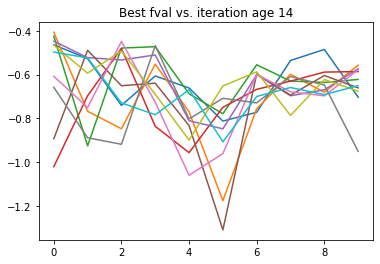

In [15]:
plt.title('Best fval vs. iteration age %d' % age)
for f_l in f_l_l:
    plt.plot(*zip(*enumerate(f_l)))
plt.show()